In [1]:
# been researching into neo4js and spark GraphX

# for now, see whether this dataset is small enough for networkx

# also work on normalizing to N2 form

# I am beginning with a simple retweet graph (nodes = users, edges = tweet propagation count)

db_path = 'data/tweets_GILLUM/gillum_tweets_N1.db'
table_name = 'tweets'


In [36]:
import networkx as nx
import numpy as np
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import string
import math
import json

In [3]:
# HELPER FUNCTIONS

def is_retweet(status):
    if status[:2] == 'RT':
        return True # todo do a more thorough check on this
    else:
        return False
    
def parse_retweet(status):
    # todo error handling
    
    status_test = status.split('RT')
    #print(status_test)
    status_test2 = status_test[1].split(':')
    #print(status_test2)
    status_clean = string.join(status_test2[1:])
    source_user = status_test2[0]
    source_user = source_user[1:] # omit the leading space (keep the @)
    #print(status_clean)
    
    return (status_clean, source_user)
    
# todo parse hashtags, parse urls, parse mentions

In [4]:
# connect to the data
db = sqlite3.connect(db_path)
print('database connected')
# cursor method
cursor = db.cursor()

database connected


In [5]:
# find the list of users
'''
start = timer()

cursor.execute('SELECT DISTINCT SCREEN_NAME FROM {}'.format(table_name))
screen_names = []
for item in cursor:
    screen_names.append('@' + item[0]) # add the @ for clarity

print(len(screen_names))

end = timer()
print("time elapsed: ")
print(end - start)
'''

'\nstart = timer()\n\ncursor.execute(\'SELECT DISTINCT SCREEN_NAME FROM {}\'.format(table_name))\nscreen_names = []\nfor item in cursor:\n    screen_names.append(\'@\' + item[0]) # add the @ for clarity\n\nprint(len(screen_names))\n\nend = timer()\nprint("time elapsed: ")\nprint(end - start)\n'

In [6]:
# build a networkx graph
'''
start = timer()

G_retweet = nx.DiGraph() # todo directed
for screen_name in screen_names:
    #print(screen_name)
    G_retweet.add_node(screen_name) # todo add metadata (friend count, etc) as properties

end = timer()
print("time elapsed: ")
print(end - start)
'''

'\nstart = timer()\n\nG_retweet = nx.DiGraph() # todo directed\nfor screen_name in screen_names:\n    #print(screen_name)\n    G_retweet.add_node(screen_name) # todo add metadata (friend count, etc) as properties\n\nend = timer()\nprint("time elapsed: ")\nprint(end - start)\n'

In [11]:
# loop through tweets and add edges where retweets are found

G_retweet = nx.DiGraph()

start = timer()

cursor.execute('SELECT status_text,screen_name FROM {}'.format(table_name))
for item in cursor:
    
    #print(item)
    
    status = item[0]
    screen_name = '@' + item[1] # add the @ character for clarity
    if is_retweet(status):
        (clean_tweet, source_user) = parse_retweet(status)        
        # add an edge to this user from the source_user
        
        WEIGHT = 1
        try:
            G_retweet[source_user][screen_name]['weight'] += WEIGHT
        except:
            G_retweet.add_edge(source_user, screen_name, weight=WEIGHT) # add a new edge
    #print('')

end = timer()
print("time elapsed: ")
print(end - start)


time elapsed: 
20.9657611371


23048 is the maximum out degree in the network


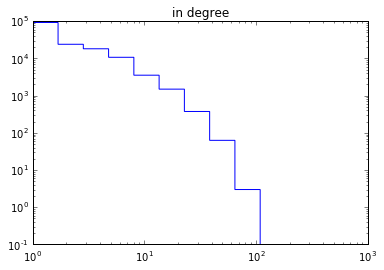

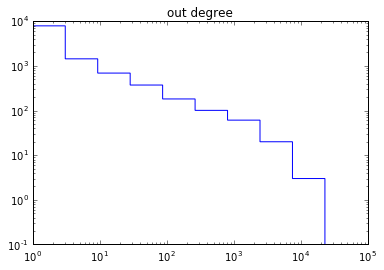

771


In [41]:
# sanity check - look at the degree distribution

in_degree_list = [x[1] for x in G_retweet.in_degree(weight='weight')]
out_degree_list = [x[1] for x in G_retweet.out_degree(weight='weight')]
#print(np.shape(in_degree_view))
#in_degree_list = list(G_retweet.in_degree(weight='w').values())
#out_degree_list = list(G_retweet.out_degree(weight='w').values())
print("{} is the maximum out degree in the network".format(max(out_degree_list)))


plt.figure()
logbins = np.logspace(0,math.log10(max(in_degree_list)),10)
plt.hist(in_degree_list,bins=logbins,histtype='step',log=True)
plt.title('in degree')
plt.gca().set_xscale("log")
plt.show()

plt.figure() # todo plot on a log axis
logbins = np.logspace(0,math.log10(max(out_degree_list)),10)
plt.hist(out_degree_list,bins=logbins,histtype='step',log=True)
plt.title('out degree')
plt.gca().set_xscale("log")
plt.show()


# add degree information as a node property
inDegrees = G_retweet.in_degree(weight='weight')
for (key,val) in inDegrees:
    G_retweet.nodes[key]['in_degree'] = val
    
outDegrees = G_retweet.out_degree(weight='weight')
for (key,val) in outDegrees:
    G_retweet.nodes[key]['out_degree'] = val

    
#nx.set_node_attributes(G_retweet, G_retweet.out_degree(weight='weight'), 'out_degree')  # same as above, different syntz
print G_retweet.nodes['@Amy_Siskind']['out_degree']

#outDegrees = G_retweet.out_degree(weight='w')
#for key in outDegrees:
#    G_retweet.nodes[key]['out_degree'] = outDegrees[key]

In [14]:
print(len(G_retweet.nodes))

157261


In [15]:
start = timer()

centrality = nx.eigenvector_centrality(G_retweet)

end = timer()
print("time elapsed: ")
print(end - start)




time elapsed: 
2125.79232164


In [16]:
import json
with open('data/retweet_eig_centr.json','w') as outfile:
    json.dump(centrality,outfile)

0.0759142676295
4.14367588526e-13


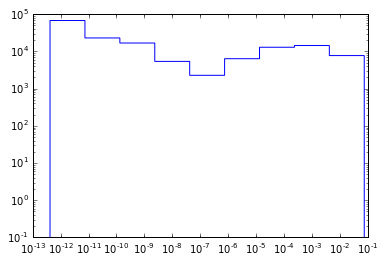

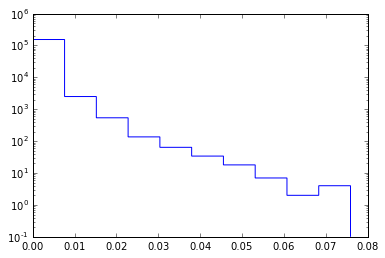

In [50]:
# testing
parsed_centrality = [val for (key,val) in centrality.items()]
print(max(parsed_centrality))
print(min(parsed_centrality))

plt.figure()
logbins = np.logspace(math.log10(min(parsed_centrality)),math.log10(max(parsed_centrality)),10)
plt.hist(parsed_centrality,bins=logbins,
        histtype='step',log=True)
plt.gca().set_xscale('log')
plt.show()

plt.figure()
plt.hist(parsed_centrality,histtype='step',log=True)
plt.show()

#plt.figure()
#n,bins = plt.hist([val for (key,val) in centrality.items()])
#plt.plot(bins,n)
#plt.show()

In [93]:
# isolate the highest out-degree nodes (influencers)
influencers = []
THRESH_out = 99.9
thresh_out = np.percentile(out_degree_list,THRESH_out)
print("{} is the threshold for out degree".format(thresh_out))
for node in G_retweet.nodes():
    #print(node)
    if G_retweet.out_degree(node,weight='weight') > thresh_out:
        influencers.append(node)
        #print(node)
print(len(influencers))    

THRESH_in = 99
thresh_in = np.percentile(in_degree_list,THRESH_in)

# todo isolate the highest in-degree nodes (spammers) and plot in relation to influencers

333.0 is the threshold for out degree
157


time elapsed: 
0.0992829519382
min scaled edge width: 1.0 max scaled edge width: 5.1743872699


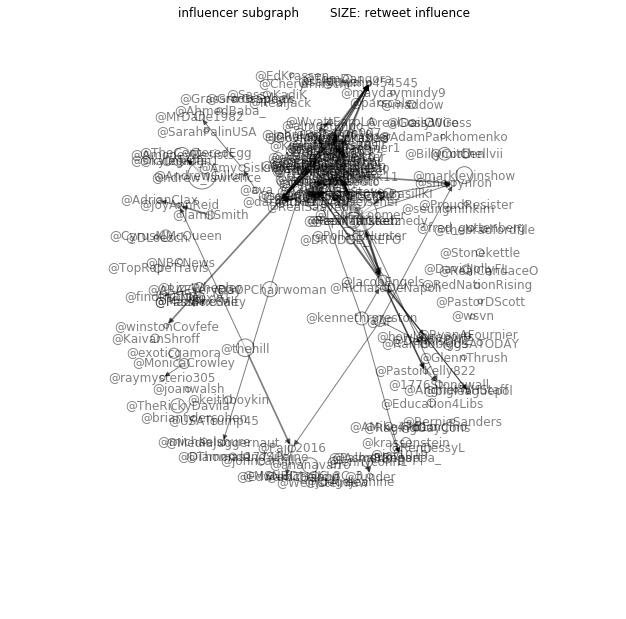

157


In [106]:
# for writable method: https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.DiGraph.subgraph.html 

start = timer()

# Create a subgraph SG based on a (possibly multigraph) G
SG = nx.DiGraph()
SG.add_nodes_from(influencers)

#print(influencers[1:10])
for pre in influencers: # since this is small network just brute force it
    SG.nodes[pre]['in_degree'] = G_retweet.nodes[pre]['in_degree']
    SG.nodes[pre]['out_degree'] = G_retweet.nodes[pre]['out_degree']
    for post in influencers:
        if G_retweet.has_edge(pre,post):
            weight = G_retweet[pre][post]["weight"]
            SG.add_edge(pre,post,weight=weight) # add a new edge
            #print('added edge')
       
end = timer()
print("time elapsed: ")
print(end - start)

SCALE = 0.05
OFFSET = 1
node_sizes = [SCALE*float(SG.nodes[key]['out_degree'])+OFFSET for key in SG.nodes()]
edge_scale = 1
edge_offset = 1
edge_widths = [edge_scale*math.log(SG.edges[key]['weight'])+edge_offset for key in SG.edges()]
print("min scaled edge width: {} max scaled edge width: {}".format(min(edge_widths),max(edge_widths)))

plt.figure(figsize=(8,8))
options = {'weight': 'w','node_color': 'white','node_size':node_sizes,'width':edge_widths,
           'alpha': 0.5, 'scale':1,
          'with_labels':True}
nx.draw_spring(SG, **options)
plt.title('influencer subgraph        SIZE: retweet influence')
plt.show()

print(len(node_sizes))



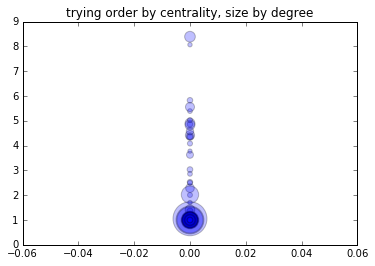

In [96]:
# draw as eigenvector centrality, for each influencer

centrality_influencers = dict((key, centrality[key]) for key in SG.nodes())

SCALE = 0.05
OFFSET = 1
node_sizes = [SCALE*float(SG.nodes[key]['out_degree'])+OFFSET for key in SG.nodes()]

# generate position dictionary
pos = {}
x_pos = 0 # instead, use the tweet timing?
yscale = 100
offset = 1
for (key,val) in centrality_influencers.items():
    y_pos = yscale*val + offset
    pos[key] = [x_pos, y_pos]

options = {'weight': 'w','node_color': 'blue','node_size':node_sizes,'width':edge_widths,
       'alpha': 0.25,'scale':1,'with_labels':True,'pos':pos}
    
plt.figure()
nx.draw_networkx_nodes(SG, **options)
plt.title('trying order by centrality, size by degree')
plt.show()

157
157


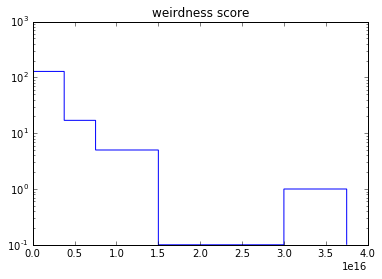

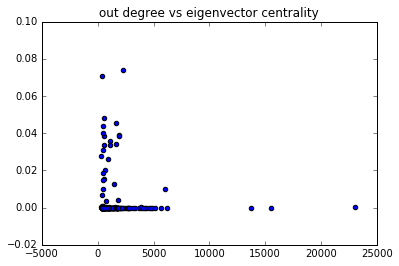

(u'@LauraLoomer', 23048)
(u'@AndrewGillum', 15539)
(u'@realDonaldTrump', 13692)


In [103]:
# scatter plot eig centrality vs out degree

c,d = [],[]
for (key,val) in centrality_influencers.items():
    c.append(val)
    d.append(SG.nodes[key]['out_degree'])

print(len(c))
print(len(d))

ratio = [deg/cen for (cen,deg) in zip(c,d)]
plt.figure()
plt.hist(ratio,histtype='step',log=True)
plt.title('weirdness score')
plt.show()


plt.figure()
plt.scatter(d,c)
plt.title('out degree vs eigenvector centrality')
plt.show()

for key in SG.nodes():
    val = SG.nodes[key]['out_degree']
    if val > 10000:
        print(key,val)


In [8]:
# todo compare centrality and degree over the whole network?



t
